# Personal Info

Name: Seyyed Amirmahdi Sadrzadeh

Student Number: 401102015

# Introduction

* Importing libraries

* Helper functions

* Plotting functions

* Set seed and set device

## Libraries

First, let's download the necessary libraries that are used throughout the assignment.

In [1]:
import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image
import requests, os
import random

## Helper Functioins

In [2]:
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')


def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

## Plotting Functions

In [3]:
def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

## Set Random Seed and Set Device

In [4]:
# For DL it's important to set the random seed so that you can have a
# baseline to compare your results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# using this function, you can be informed whether the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [6]:
SEED = 1404
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 1404 has been set.
GPU is enabled in this notebook.


# Download EMNIST dataset

* For this assignment, we will use the EMNIST letters dataset, which consists of binarized images of handwritten characters.

* We only keep the images that correspond to **X** and **O**. Then, we will train a CNN to classify an image as either an **X** or an **O**.

In [7]:
# webpage: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)




Extracting the files...



# Dataset/DataLoader Functions

In [8]:
def get_Xvs0_dataset(normalize=False, download=False):
  """
  Load Dataset

  Args:
    normalize: boolean
      If true, normalise dataloader
    download: boolean
      If true, download dataset

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  if normalize:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        ])

  emnist_train = datasets.EMNIST(root='.',
                                 split='letters',
                                 download=download,
                                 train=True,
                                 transform=transform)
  emnist_test = datasets.EMNIST(root='.',
                                split='letters',
                                download=download,
                                train=False,
                                transform=transform)

  # Only want O (15) and X (24) labels
  train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
  emnist_train.targets = emnist_train.targets[train_idx]
  emnist_train.data = emnist_train.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

  test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
  emnist_test.targets = emnist_test.targets[test_idx]
  emnist_test.data = emnist_test.data[test_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

  return emnist_train, emnist_test


def get_data_loaders(train_dataset, test_dataset,
                     batch_size=32, seed=0):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    batch_size: int
      Batch Size
    seed: int
      Set seed for reproducibility

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, test_loader

In [9]:
emnist_train, emnist_test = get_Xvs0_dataset(normalize=False, download=False)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 4
o_img_idx = 15

Here, you can see a couple of samples from the dataset.

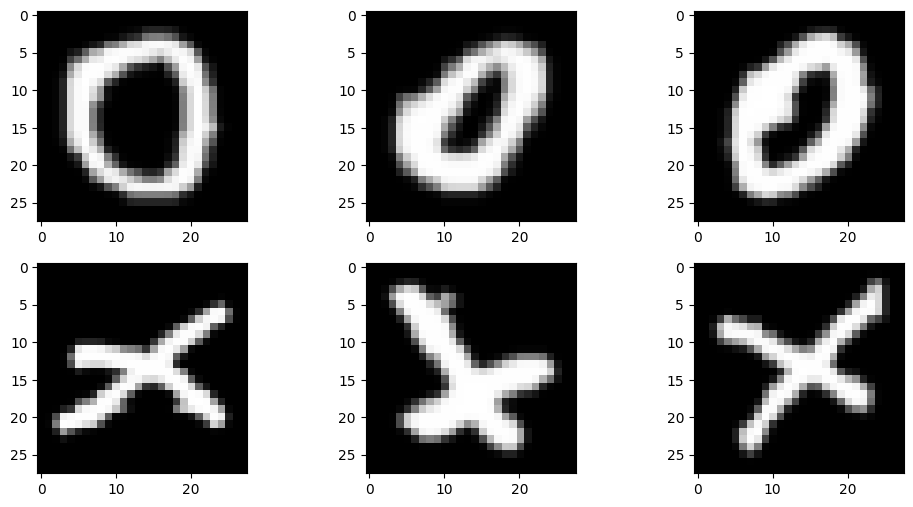

In [10]:
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))
ax1.imshow(emnist_train[0][0].reshape(28, 28), cmap='gray')
ax2.imshow(emnist_train[10][0].reshape(28, 28), cmap='gray')
ax3.imshow(emnist_train[15][0].reshape(28, 28), cmap='gray')
ax4.imshow(emnist_train[6][0].reshape(28, 28), cmap='gray')
ax5.imshow(emnist_train[3][0].reshape(28, 28), cmap='gray')
ax6.imshow(emnist_train[4][0].reshape(28, 28), cmap='gray')
plt.show()

# A visualization of the process

**Assignment starts from here, fill the missing codes (...)**

## Multiple filters

* For the following network, we set up 3 filters and run them on an image of the dataset from the X class.

In [11]:
class Net(nn.Module):

  def __init__(self, padding=0):
    """
    Initialize parameters of Net

    Args:
      padding: int or tuple, optional. Default: 0

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    #####################################################################
    # TODO:
    # 1) Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    # 2) Set this tensor as the weight of self.conv1 --> use torch.nn.Parameter(...)

    # comment the line below to test your code
    # raise NotImplementedError(" Complete the initialization first")
    #####################################################################

    # 1)
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3])

    # 2)
    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    #####################################################################
    # TODO:
    # 3) Apply the conv layer to the input

    # comment the line below to test your code
    # raise NotImplementedError(" Apply the conv layer to the input")
    #####################################################################

    # 3)
    x = self.conv1(x)
    return x

**Q1: Why did we  add a negative bias?**

We added a negative bias to the convolutional filters to ensure the activation occurs only when there's a sufficiently strong correlation between the filter and specific patterns in the input. Without a negative bias, the convolutional filters may activate even for weak or unrelated patterns, making the network less discriminative.

The negative bias essentially raises the activation threshold, meaning that only clear and strong matches between the input and the kernels result in positive (activated) outputs. This helps the CNN learn more distinct features, leading to better feature extraction and classification performance.



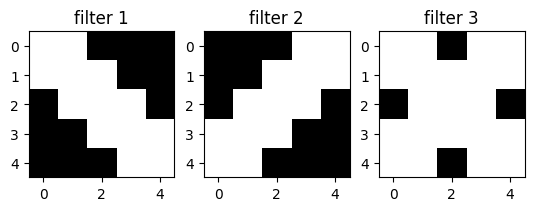

In [12]:
# Visualizing the filters

net = Net().to(DEVICE)
fig, (ax11, ax12, ax13) = plt.subplots(1, 3)
# Show the filters
ax11.set_title("filter 1")
ax11.imshow(net.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax12.set_title("filter 2")
ax12.imshow(net.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 3")
ax13.imshow(net.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

**Q2: How do you think these filters would help to recognize X?**

These filters contain carefully designed patterns composed of diagonal and cross-shaped edges, which strongly resemble key features of the letter "X". Specifically:



*   Filter 1 and Filter 2 capture diagonal edge patterns going in opposite directions. Since the letter "X" is composed of two intersecting diagonal lines, these filters will effectively detect those diagonal features.
*   Filter 3 is designed to recognize cross-like patterns, explicitly matching the intersection at the center of the letter "X".


Thus, when an "X" passes through these filters, we expect strong activations indicating the presence of these characteristic diagonal and intersecting patterns, facilitating robust detection and classification of the "X" character.

In [13]:
# Applying the filters to the images


#####################################################################
# TODO:
# 1) Pass the the image of 'X' and 'O' through the network to see the output

# comment the line below to test your code
# raise NotImplementedError(" No filter has implemented to the images")
#####################################################################

net = Net().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)

# 1)
output_x = net(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)

# 1)
output_o = net(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

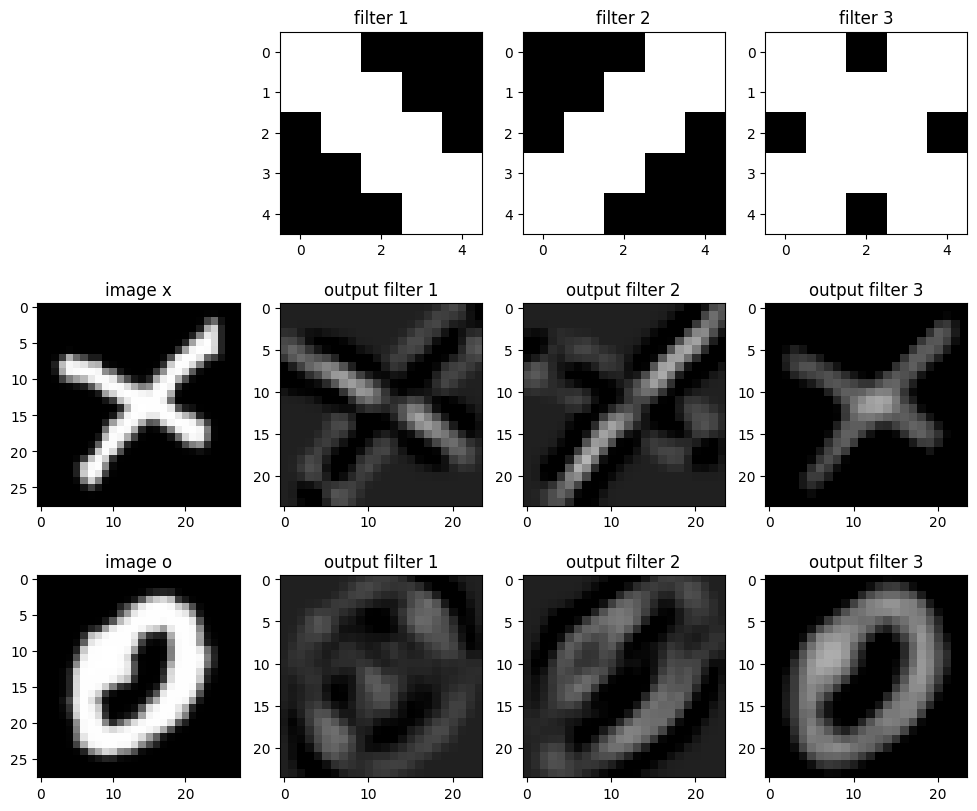

In [14]:
# Viewing what the output of the applied filters looks like

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4, figsize=(12, 10))

# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

## ReLU

* ReLU introduces non-linearity into our model, allowing to learn a more complex function that can better predict the class of an image.

* Let's incorporate ReLU into the previous model and visualize the output.


In [17]:
class Net2(nn.Module):

  def __init__(self, padding=0):
    """
    Initialize Net2 parameters

    Args:
      padding: int or tuple, optional. Default: 0

    Returns:
      Nothing
    """
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])



    #####################################################################
    # TODO:
    # 1) Stack all kernels in one tensor
    # 2) Set this tensor as the weight of self.conv1

    # comment the line below to test your code
    # raise NotImplementedError(" Complete the initialization first")
    #####################################################################

    # 1)
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3])

    # 2)
    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net2

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution + ReLU output
    """

    #####################################################################
    # TODO:
    # 1) Apply conv layer and ReLU to the input

    # comment the line below to test your code
    # raise NotImplementedError(" Apply the conv layer and ReLU to the input")
    #####################################################################

    # 3)
    # Apply convolution
    x = self.conv1(x)
    # Apply ReLU activation
    x = F.relu(x)
    return x

In [18]:
# Apply the filters and relus to the images.

net2 = Net2().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_relu = net2(x_img)
output_x_relu = output_x_relu.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_relu = net2(o_img)
output_o_relu = output_o_relu.squeeze(dim=0).detach().cpu().numpy()

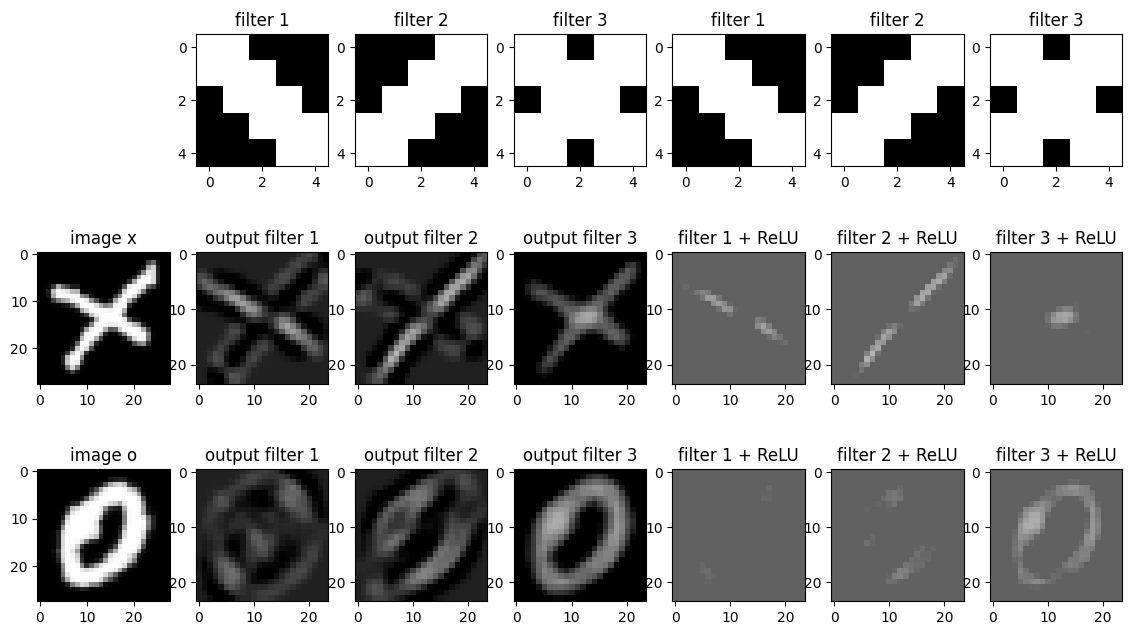

In [19]:
# Viewing what the output of the applied filters looks like

fig, ((ax11, ax12, ax13, ax14, ax15, ax16, ax17),
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27),
      (ax31, ax32, ax33, ax34, ax35, ax36, ax37)) = plt.subplots(3, 4 + 3,
                                                                 figsize=(14, 8))
# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

ax15.set_title("filter 1")
ax15.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax16.set_title("filter 2")
ax16.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax17.set_title("filter 3")
ax17.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to `x`
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

ax25.set_title("filter 1 + ReLU")
ax25.imshow(output_x_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax26.set_title("filter 2 + ReLU")
ax26.imshow(output_x_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax27.set_title("filter 3 + ReLU")
ax27.imshow(output_x_relu[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to `o`
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)

ax35.set_title("filter 1 + ReLU")
ax35.imshow(output_o_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax36.set_title("filter 2 + ReLU")
ax36.imshow(output_o_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax37.set_title("filter 3 + ReLU")
ax37.imshow(output_o_relu[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

**Q3: How do you think the ReLU activations help strengthen the features necessary to detect an image?**

The ReLU (Rectified Linear Unit) activation helps strengthen the important features by introducing non-linearity into the model. Specifically, ReLU achieves this by:

*   **Suppressing Negative Activations:**
ReLU converts all negative values to zero. This effectively removes weak or irrelevant responses from filters, focusing attention only on features that strongly match the learned patterns.
*   **Enhancing Feature Contrast:**
By preserving only positive activations, ReLU amplifies the difference between relevant features (high activations) and non-relevant features (low or negative activations). This contrast makes the important patterns stand out clearly.
*   **Non-linear Representation:**
Without ReLU (or other nonlinearities), multiple layers would collapse to a single linear operation. By using ReLU, the network becomes capable of learning complex patterns and combinations of features, making it better suited for recognizing intricate shapes like the letter "X".

Overall, the ReLU activation significantly improves the network's capability to extract meaningful and discriminative features from the input images.

## MaxPooling

* Now Let's implement MaxPooling. We use a kernel of size 2 and stride of 2 for the MaxPooling layer.

In [21]:
class Net3(nn.Module):

  def __init__(self, padding=0, stride=2):
    """
    Initialise parameters of Net3

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0
      stride: int
        Stride

    Returns:
      Nothing
    """
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                            padding=padding)

    # First kernel
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    #####################################################################
    # TODO:
    # 1) Stack all kernels in one tensor
    # 2) Set this tensor as the weight of self.conv1
    # comment the line below to test your code
    # raise NotImplementedError(" Complete the initialization first")

    # 3) Define a MaxPooling layer with a kernel of size 2 and stride of 2 --> there is an arg for stride in __init__
    # comment the line below to test your function
    # raise NotImplementedError("Define the maxpool layer")
    #####################################################################

    # 1)
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3])

    # 2)
    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

    # 3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=stride)

  def forward(self, x):
    """
    Forward Pass of Net3

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution + ReLU + Pooling output
    """
    #####################################################################
    # TODO:
    # 4) Apply conv layer + ReLU + maxpool layer to the input

    # comment the line below to test your code
    # raise NotImplementedError(" Apply conv layer + ReLU + maxpool to the input")
    #####################################################################

    # 4)
    # Apply convolution
    x = self.conv1(x)
    # Apply ReLU activation
    x = F.relu(x)
    # Apply MaxPooling
    x = self.pool(x)
    return x


In [22]:
# Apply the filters and relus to the images.

net3 = Net3().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_pool = net3(x_img)
output_x_pool = output_x_pool.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_pool = net3(o_img)
output_o_pool = output_o_pool.squeeze(dim=0).detach().cpu().numpy()

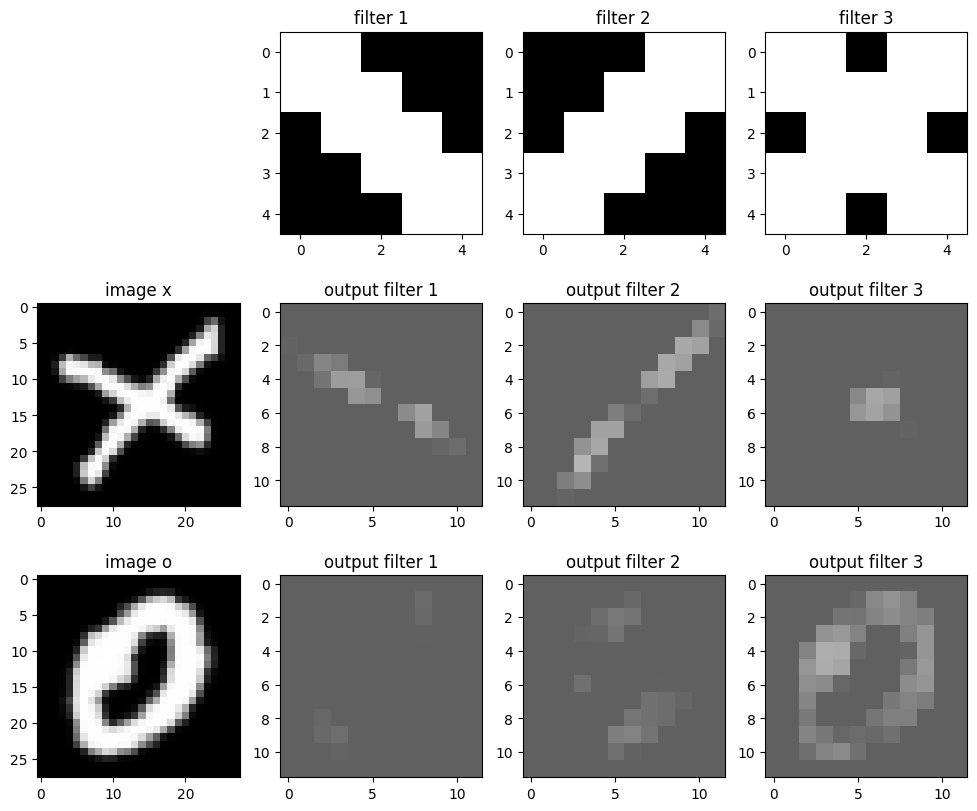

In [23]:
# Viewing what the output of the applied filters looks like

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4, figsize=(12, 10))

# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x_pool[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o_pool[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

* You can observe that after implementing Maxpool layer, the size of the output  being half of what you we after the ReLU section.

* Despite the reduction in the size of the output, the important or high-level features in the output still remains intact.

# implement a CNN

For this section, you're going to create a CNN.

In [ ]:
# Train/Test Functions
# You will code your training loop in HW_CNN_part2, you can run this cell for this HW for now

def train(model, device, train_loader, epochs):
  """
  Training function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    train_loader: torch.loader
      Training Set
    epochs: int
      Number of epochs

  Returns:
    Nothing
  """
  model.train()

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as tepoch:
      for data, target in tepoch:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        tepoch.set_postfix(loss=loss.item())
        time.sleep(0.1)

def test(model, device, data_loader):
  """
  Test function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    data_loader: torch.loader
      Test Set

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return acc

In [ ]:
set_seed(SEED)
emnist_train, emnist_test = get_Xvs0_dataset(normalize=True)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

Random seed 1404 has been set.


In [ ]:
class EMNIST_Net(nn.Module):
  """
  Neural network instance with following structure
  # Convolutional Layer 1: 1 --> 32, kernel_size=3
  # Convolutional Block 2: 32 --> 64, kernel_size=3 + maxpooling
  # Fully Connected Layer 1: 9216 --> 128
  # Fully Connected Layer 2: 128 --> 2
  """

  def __init__(self):
    """
    Initialize parameters of EMNISTNet

    Args:
      None

    Returns:
      Nothing
    """
    super(EMNIST_Net, self).__init__()


    ####################################################################
    # TODO:
    # 1) Define the required layers according to the given structure

    # comment the line below to test your code
    raise NotImplementedError("Define the required layers")
    ####################################################################

    # 1)
    self.conv1 = ...
    self.conv2 = ...
    self.fc1 = ...
    self.fc2 = ...
    self.pool = ...

  def forward(self, x):
    """
    Forward pass of EMNISTNet

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output of final fully connected layer
    """

    ####################################################################
    # TODO:
    # 2) Define forward pass for any input x (don't forget relus)
    # hint --> don't forget to flatten the image when it passes from Convolution Layers to Linear Layers (torch.flatten())

    # comment the line below to test your code
    raise NotImplementedError("Define forward pass for any input x")
    ####################################################################

    # 2)
    x = ...
    x = ...
    x = ...
    x = ...
    x = ...
    x = ...
    x = ...
    x = ...
    x = ...
    return x


emnist_net = EMNIST_Net().to(DEVICE)
print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
train(emnist_net, DEVICE, train_loader, 1)

print(f'Test accuracy is: {test(emnist_net, DEVICE, test_loader)}')

Total Parameters in Network    1198850


  0%|          | 0/300 [00:00<?, ?batch/s]

Test accuracy is: 99.1875


## Softmax

* Now let's use softmax function which converts a real value to a value between 0 and 1, that can be interpreted as a probability.

Input1:


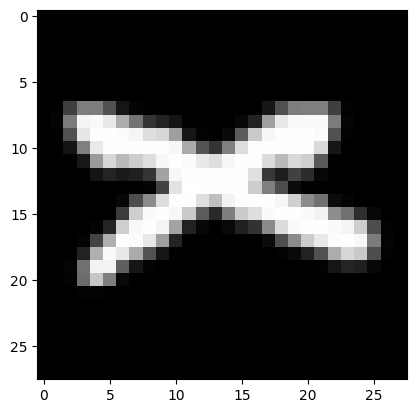


Result: tensor([[0.0015, 0.9985]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being an 'O': 0.0014562272699549794
Confidence of image being an 'X': 0.9985437393188477

--------------------------

Input2:


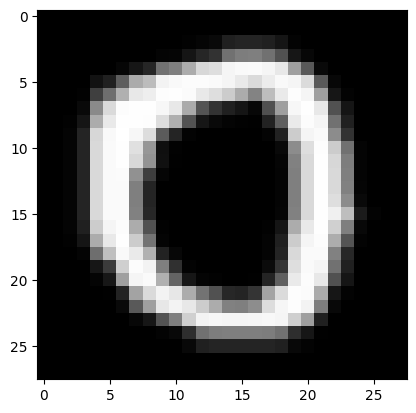


Result: tensor([[9.9988e-01, 1.2062e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being an 'O': 0.9998793601989746
Confidence of image being an 'X': 0.00012061846791766584


In [ ]:
# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 11
o_img_idx = 0

print("Input1:")
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))


#####################################################################
# TODO:
# 1) Apply softmax to the output logits

# comment the line below to test your code
raise NotImplementedError("Apply softmax")
#####################################################################

plt.show()
output = emnist_net(x_img)

# 1)
result = ...
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

print("\n--------------------------\n")

print("Input2:")
o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(o_img)

# 1)
result = ...
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

* This is evident from the softmax output, which shows the probabilities of the image belonging to each of the classes.

# Further tasks

## Task 1: Compare with a Fully Connected Network

Train a simple fully connected neural network (MLP) on the same dataset. Compare its performance with your CNN in terms of accuracy, number of parameters, and training time. Explain why CNN performs better or worse.

In [ ]:
# YOUR CODE HERE

## Task 2: Add Evaluation Metrics

In addition to overall accuracy, compute and report:
* Confusion matrix

* Model performance metrics


In [ ]:
# YOUR CODE HERE

## Task 3: Compare Optimizers

Compare model performance when trained with SGD, Adam, and RMSProp. Plot the loss curves.

In [ ]:
# YOUR CODE HERE

## Task 4: Compare Activation Functions

Replace ReLU with Tanh or LeakyReLU. How does that affect performance?

In [ ]:
# YOURCODE HERE

## Task 5: Train a Deeper CNN

Extend the network with your desired additional layers. Does it help or hurt performance?

In [ ]:
# YOUR CODE HERE